# Parte A

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from pickle import NONE
from sklearn import linear_model
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import joblib
from sklearn.metrics import precision_score, recall_score

# Apartado 1

Para generar el conjunto de datos nos vamos a apoyar en la clase que implementamos en la practica 2. Esta clase tiene el constructor y dos métodos:
- Constructor:
  - Numero de instancias
  - Presion arterial: vector con los valores de la presion arterial
  - Colesterol: vector con los valores de colesterol
  - x : vector que almacena pares de (presion, colesterol)
  - y : vector que almacena la categoría de cada instancia
  - x_normalizado : mismo vector que x pero con los datos normalizados
  - probabilidades : vector que almacena las probabilidades de cada instancia
  - umbral : umbral que nos permitirá categorizar las instancias
  - scaler: objeto StandarScaler que nos permitirá normalizar los datos

- Generar datos: genera datos de presion arterial y colesterol con una distribucion

- Clasificar datos: clasifica los datos generados( 1 = problema CV, 0 = persona normal). Para hacer esta clasificacion normalizamos los datos, y obtenemos una propabilidad multiplicando ambos atributos; despues establecemos un umbral que determinará la categoría a la que pertenece cada instancia



In [2]:

np.random.seed(42)

class Data:


  def __init__(self,num_instancias):

    self.num_instancias = num_instancias

    #Datos
    self.presion_arterial =None
    self.colesterol = None

    self.x =  None #vector que almacena todos los datos[[pa_1,c_1,f1], [pa_2,c_2,f2] ....]
    self.y =None #Clase a las que pertenece cada instancia

    self.x_normalizado =None
    self.probabilidades =None
    self.umbral = 0.6

    #scaler
    self.scaler = StandardScaler()


  def generar_datos(self):

    # Generar presión arterial sistólica (distribución normal con valores entre 70 y 180)
    self.presion_arterial = np.random.normal(loc=110, scale=15, size=self.num_instancias)
    self.presion_arterial = np.clip(self.presion_arterial, 70, 180)

    # Generar colesterol (distribución normal con valores entre 120 y 250)
    self.colesterol = np.random.normal(loc=170, scale=30, size=self.num_instancias)
    self.colesterol = np.clip(self.colesterol, 120, 250)

    #Lo añadimos todo en un mismo vector: [[pa_1,c_1,f1], [pa_2,c_2,f2] ....]
    self.x = np.column_stack((self.presion_arterial, self.colesterol))

  def clasificar_datos(self):
    #Normalizamos los datos
    self.scaler.fit(self.x)
    self.x_normalizado = self.scaler.transform(self.x)

    #Calculamos las probabilidades meidante la multiplicacion de los 3 atributos
    self.probabilidades = np.prod(self.x_normalizado, axis=1)

    #Clasificamos las instancias con el nuevo umbral
    self.y = (self.probabilidades >= self.umbral).astype(int)


Generamos datos y los clasificamos segun la probabilidad y definiendo el umbral

In [3]:
#Generamos el dataset
dataset = Data(num_instancias=100000) #100.000 instancias
dataset.generar_datos()
dataset.clasificar_datos()

print("Numero de personas con problemas CV:",len(dataset.y[dataset.y==1]))

Numero de personas con problemas CV: 18587


Representamos el conjunto de datos:

In [4]:
def dibujarPuntos(x,y):
  presion_arterial = x[:, 0]  # Presión arterial
  colesterol  = x[:, 1]  # Colesterol

    # Diccionario de mapeo para cambiar las etiquetas de la leyenda


  plt.figure(figsize=(8,6))
  scatter = sns.scatterplot(
    x=presion_arterial,
    y=colesterol,
    hue=y,  # Mapeo de etiquetas
    style=y,  # Mismo mapeo para estilos
    markers={0: 'o', 1: 'X'},
    palette={0: 'blue', 1: 'orange'}
  )
  plt.title("Clasificacion real")
    # Etiquetas y título
  plt.xlabel("Presión Arterial")
  plt.ylabel("Colesterol")

  plt.show()

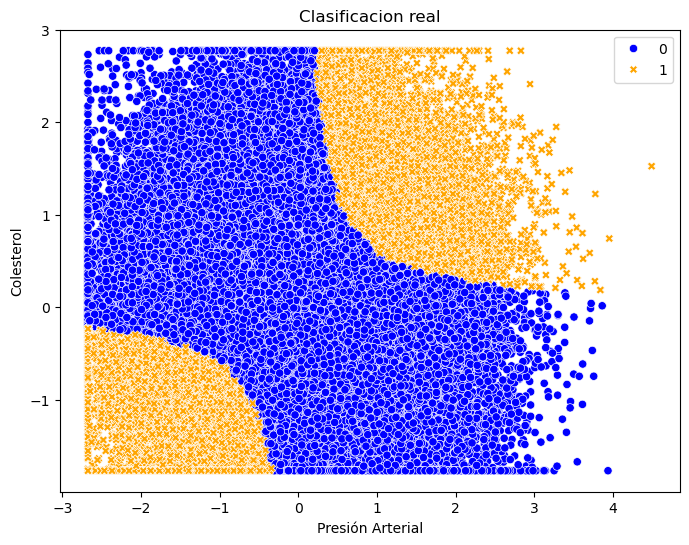

In [5]:
dibujarPuntos(dataset.x_normalizado,dataset.y)


# Apartado 2
Para dividir el conjunto de datos hemos decidido hacer una separacion 80-20: 80% de las muestras para entrenamiento y 20% para test.



In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset.x_normalizado, dataset.y, test_size=0.2, random_state=42)

# Apartado 3

En este apartado vamos a implementar una red neuronal con las siguientes características:

- 2 capas ocultas: la primera con 100 nodos y la segunda con 50 nodos
- La funcion de activación es RELU
- Algoritmo de optimizacion Adam
- Numero de iteraciones : 500

Hemos decidio tambien guardar el modelo entrenado en un archivo para no tener que perder el tiempo entrenandolo otra vez en futuras ejecuciones y pruebas del resultado

In [7]:
#Definimos el modelo
mlp1 = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)

#Entrenamos
mlp1.fit(X_train,y_train)

#Guardamos en un archivo el modelo entrenado
joblib.dump(mlp1, "modelo1.pkl")

['modelo1.pkl']

# Apartado 4, 5 y 6

Para realizar el estudio de los resultados vamos a definir una funcion que nos permita dibujar los puntos y que recibirá como entrada:
- x_test: datos de presion arterial y colesterol
- y_test: clasificacion de las instancias
- modelo: red neuronal para poder calcular las predicciones

Además esta función calculará la precisión y la exhaustividad del modelo

In [8]:
def dibujarPredicciones(x_test,y_test,modelo):

  #Separamos los datos
  presion_arterial = x_test[:, 0]
  colesterol  = x_test[:, 1]

  #Calculamos el resultado de la red neuronal
  y_prediccion = modelo.predict(x_test)

  # Creamos la figura
  plt.figure(figsize=(8,6))
  sns.scatterplot(x= presion_arterial, y=colesterol, hue=y_prediccion, style=y_prediccion, markers={0: 'o', 1: 'X'}, palette={0: 'blue', 1: 'orange'})
  plt.title("Predicciones")
  plt.show()

  precision= precision_score(y_test, y_prediccion, pos_label=1)
  recall = recall_score(y_test, y_prediccion, pos_label=1)

  print(f'Precisión: {precision:.4f}')
  print(f'Recall: {recall:.4f}')



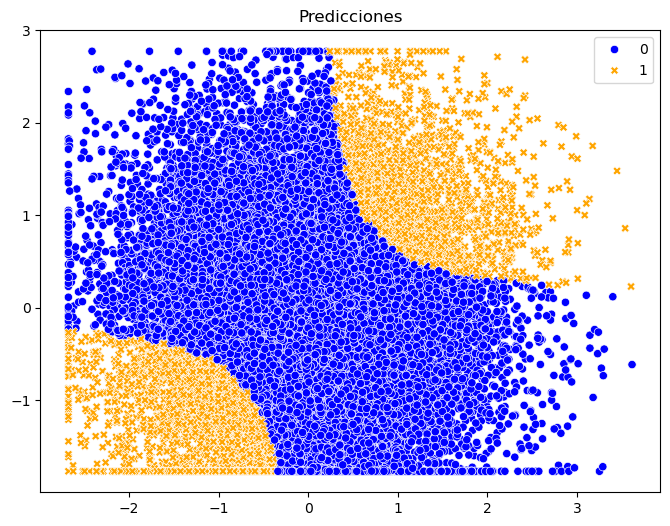

Precisión: 1.0000
Recall: 0.9879


In [9]:
dibujarPredicciones(X_test,y_test,mlp1)

Observamos que el modelo entrenado es bastante bueno y que no ha sobreaprendido, pues los resultados obtenidos con el conjunto de test son muy buenos.

# Apartados 7 y 8
En este apartado vamos a definir distintas configuraciones de la red para comparar el comportamiento. Sin embargo, primero vamos a definir un nuevo conjunto de datos y vamos a ver como se comporta el primer modelo con datos nuevos.

In [11]:
#Nuevo conjunto de datos
dataset_nuevo= Data(num_instancias=20000)
dataset_nuevo.generar_datos()
dataset_nuevo.clasificar_datos()

Introducimos los nuevos datos por la red:



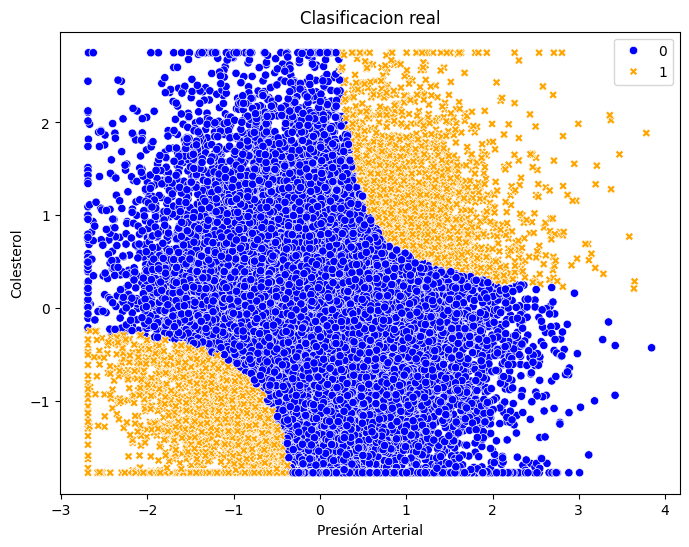

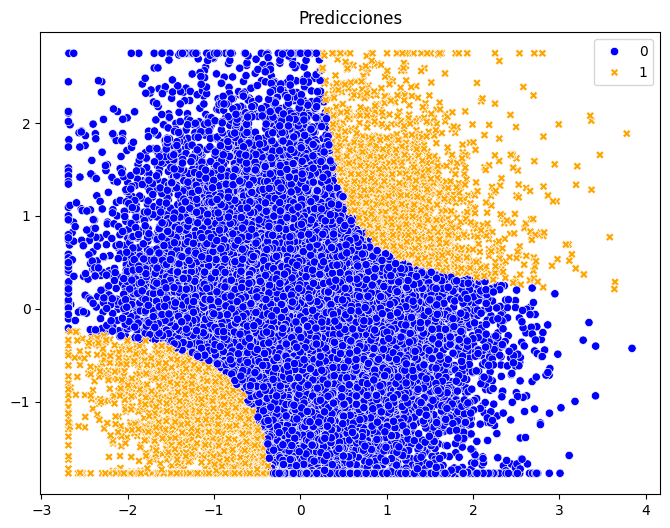

Precisión: 1.0000
Recall: 0.9857


In [12]:
dibujarPuntos(dataset_nuevo.x_normalizado,dataset_nuevo.y)
dibujarPredicciones(dataset_nuevo.x_normalizado, dataset_nuevo.y,mlp1)

Con este nuevo conjunto de datos generados volvemos a confirmar que, efectivamente, nuestro primer modelo no ha sobreaprendido y además su comportamiento es muy bueno respecto a datos nuevos generados

# Modelo 2

Definimos un nuevo modelo con las siguientes características:

- 1 capa oculta con 100 nodos
- La funcion de activación es RELU
- Algoritmo de optimizacion Adam
- Numero de iteraciones : 200

Este modelo lo entrenameros con el mismo conjunto de entrenamiento que el anterior

In [13]:
#Definimos el nuevo modelo
mlp2 = MLPClassifier(hidden_layer_sizes=(100), activation='relu', solver='adam', max_iter=200,random_state=42)
mlp2.fit(X_train,y_train)
joblib.dump(mlp2, "modelo2.pkl")

['modelo2.pkl']

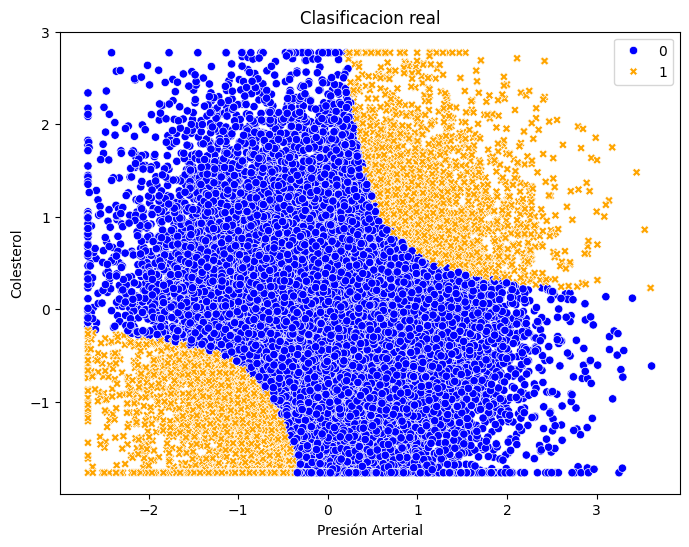

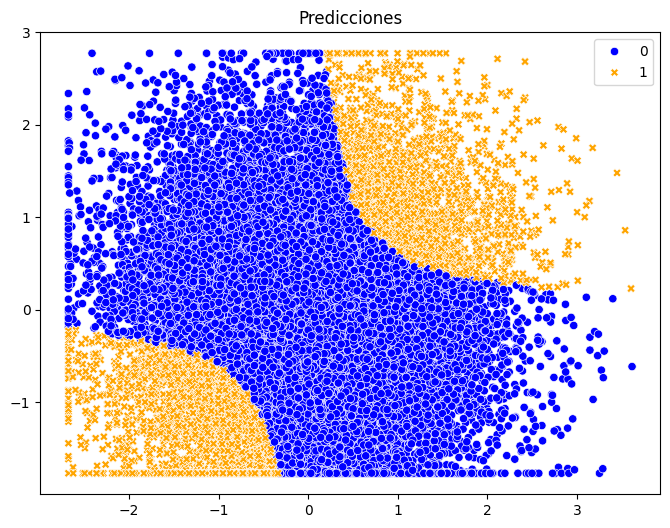

Precisión: 0.9936
Recall: 0.9970


In [14]:
dibujarPuntos(X_test,y_test)
dibujarPredicciones(X_test,y_test,mlp2)

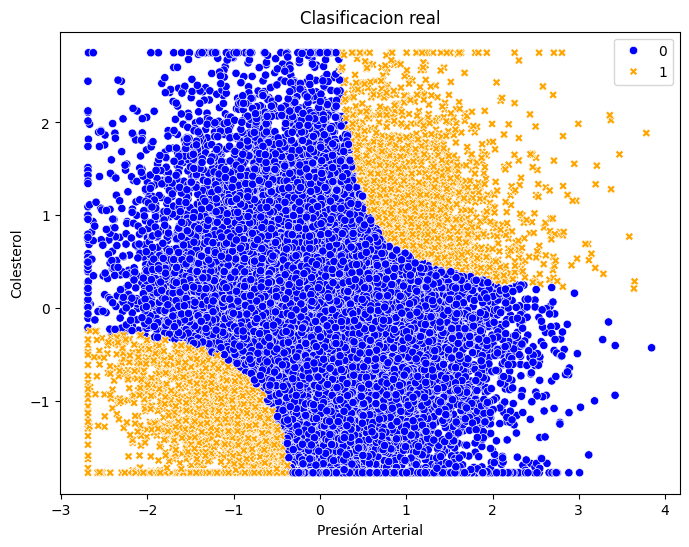

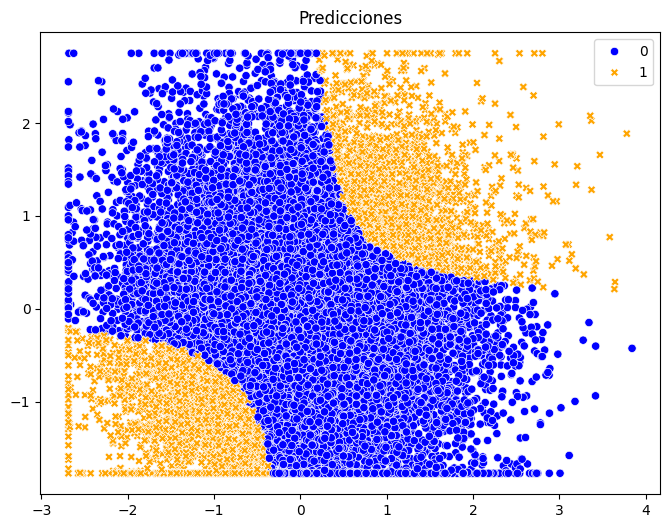

Precisión: 0.9942
Recall: 0.9959


In [15]:
#Pasamos el dataset nuevo
dibujarPuntos(dataset_nuevo.x_normalizado,dataset_nuevo.y)
dibujarPredicciones(dataset_nuevo.x_normalizado,dataset_nuevo.y,mlp2)

Al igual que el primer modelo, se comporta bastante bien con datos nuevos

# Modelo 3
Viendo el buen funcionamiento de los modelos anteriores, definimos un nuevo modelo mucho mas simple con las siguientes características:

- 1 capa oculta con 3 nodos
- La funcion de activación es RELU
- Algoritmo de optimizacion lbfgs
- Numero de iteraciones : 50

Este modelo lo entrenameros con otra particion del dataset : 50-50.

In [23]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dataset.x_normalizado, dataset.y, test_size=0.5, random_state=42)
mlp3 = MLPClassifier(hidden_layer_sizes=(3), activation='relu', solver='lbfgs', max_iter=50,random_state=42)
mlp3.fit(X_train_2,y_train_2)
joblib.dump(mlp3, "modelo3.pkl")

['modelo3.pkl']

In [ ]:
mlp3 =  joblib.load("modelo3.pkl")

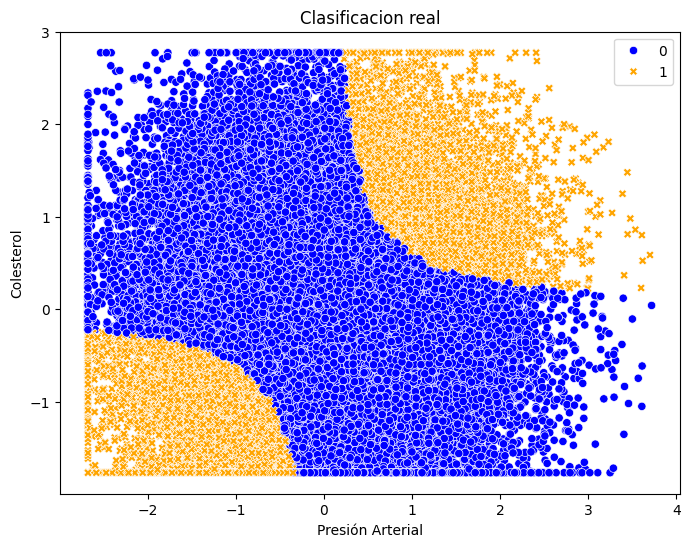

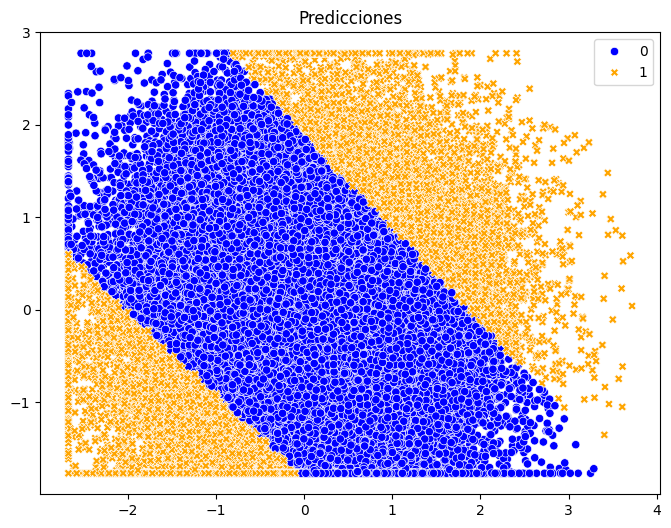

Precisión: 0.8109
Recall: 0.8272


In [24]:
dibujarPuntos(X_test_2,y_test_2)
dibujarPredicciones(X_test_2,y_test_2,mlp3)

Aquí ya observamos una clara diferencia entre los valores reales y las predicciones del modelo.La precision y el recall han disminuido; sin embargo, los resultados no son tan malos pues tenemos una precision y un recall del 80%: un notable. Probemos con el nuevo conjunto:

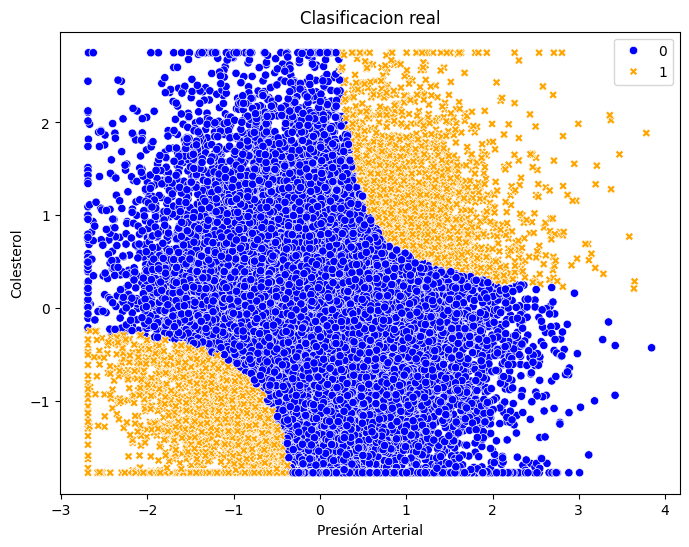

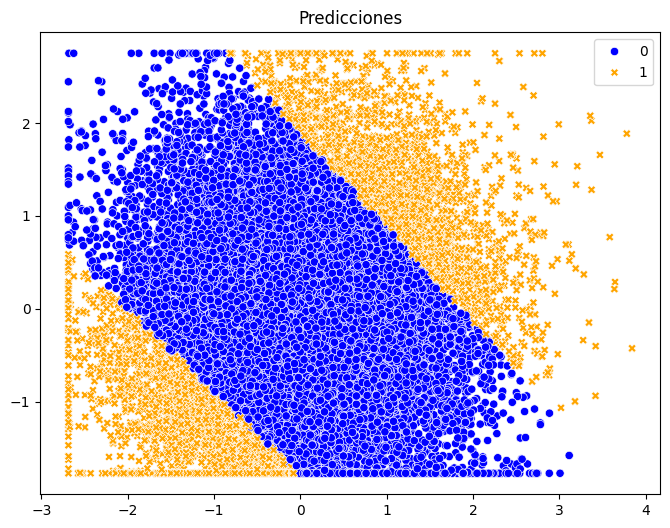

Precisión: 0.8114
Recall: 0.8179


In [26]:
dibujarPuntos(dataset_nuevo.x_normalizado,dataset_nuevo.y)
dibujarPredicciones(dataset_nuevo.x_normalizado,dataset_nuevo.y,mlp3)

# Apartado 9

Tras probar distintas configuraciones, algunas relativamente complejas con dos capas ocultas y otras muy sencillas como el modelo 3, hemos obtenido resultados muy buenos en general. Creemos que esto se debe a la sencillez del modelo en sí y la gran cantidad de datos generados. Al final, la red neuronal solo tiene como entrada dos datos, y el rango de valores para cada uno de ellos no es estremadamente alto ( valores entre 70 y 180 para el colesterol, y valores entre 120 y 250 para la presion), luego con tanto de volumen de datos creemos que es muy probable que se hayan podido generar casi todas las posibles combinaciones de pares (colesterol, presion arterial) y esto ha permitido a la red neuronal aprenderse practicamente todos los estados posibles.

Obviamente, el mejor modelo es el primero; sin embargo, teniendo en cuenta lo que acabamos de comentar, creemos que cualquier modelo un pelin mas complejo que el modelo 3 sería suficiente para obtener buenos resultados: no es necesario implementar una red extramadamente compleja.